# NBA Players Stats Similarity

The goal of this project is to cluster NBA players based on the similarity of their stats.

In [1]:
%matplotlib inline

import re
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import wikipedia
import urllib

from skimage import io
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from impyute.imputation.cs import fast_knn

random_state = 101

In [2]:
dataset = pd.read_csv("../files/nba_stats.csv")
dataset_copy = dataset.copy()

## Data description

The data has all the stats of players from 2000 to 2018. This dataset was generated using the scripts that can be found into the 'scrapping' folder. Also, the [NBA Stat Glossay](https://stats.nba.com/help/glossary/) may assist you to understand what is the meaning of each feature.

In [3]:
dataset.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
0,1,Tariq Abdul-Wahad,SG,25,TOT,61,56,1578,274,646,...,101,190,291,98,59,28,106,147,697,2000
1,1,Tariq Abdul-Wahad,SG,25,ORL,46,46,1205,223,515,...,77,162,239,72,53,16,87,116,563,2000
2,1,Tariq Abdul-Wahad,SG,25,DEN,15,10,373,51,131,...,24,28,52,26,6,12,19,31,134,2000
3,2,Shareef Abdur-Rahim,SF,23,VAN,82,82,3223,594,1277,...,218,607,825,271,89,87,249,244,1663,2000
4,3,Cory Alexander,PG,26,DEN,29,2,329,28,98,...,8,34,42,58,24,2,28,39,82,2000


In [4]:
print("Total number of instances and features: (%s - %s)" % dataset.shape)

Total number of instances and features: (10868 - 31)


In [5]:
dataset.columns = [i.lower() for i in dataset.columns]

### Missing values

There are a few missing values for each variable (considering the total which is 10,868)

In [6]:
# dataset.isnull().sum() would give me the complete list,
# but in this way I can see only the features that really have missing values

nulls = dataset.columns[dataset.isnull().any()]
nulls_copy = nulls.copy()

for null in nulls:
    print("Variable: %s missing %s entrys" % (null, dataset[null].isnull().sum()))

Variable: fg% missing 57 entrys
Variable: 3p% missing 1818 entrys
Variable: 2p% missing 93 entrys
Variable: efg% missing 57 entrys
Variable: ft% missing 501 entrys


I decided to impute this values using a similarity based approach, for that, I'm going to use the [Impyute](https://impyute.readthedocs.io/en/master/index.html) library with the [K-Nearest Neighbors algorithm (KNN)](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) <br>

Before diving into the imputation, I will encode the Position and Team features to transform into numeric data.

There are 11 distinct positions that can vary between only one position or two, e.g. Shooting Guard or Shooting Guard and Small Forward. Also, there are 38 teams on that list. From 2000 to 2018, some teams have changed their shirts, for instance Seattle SuperSonics changed to Oklahoma City Thunder.

In [7]:
encode_variables = ["pos", "tm"]
encoders = [LabelEncoder() for i in range(len(encode_variables))]

for var, encoder in zip(encode_variables, encoders):
    dataset[var] = encoder.fit_transform(dataset[var].values)

In [8]:
dataset.head()

,rk,player,pos,age,tm,g,gs,mp,fg,fga,...,orb,drb,trb,ast,stl,blk,tov,pf,pts,year
0,1,Tariq Abdul-Wahad,11,25,34,61,56,1578,274,646,...,101,190,291,98,59,28,106,147,697,2000
1,1,Tariq Abdul-Wahad,11,25,26,46,46,1205,223,515,...,77,162,239,72,53,16,87,116,563,2000
2,1,Tariq Abdul-Wahad,11,25,9,15,10,373,51,131,...,24,28,52,26,6,12,19,31,134,2000
3,2,Shareef Abdur-Rahim,8,23,36,82,82,3223,594,1277,...,218,607,825,271,89,87,249,244,1663,2000
4,3,Cory Alexander,5,26,9,29,2,329,28,98,...,8,34,42,58,24,2,28,39,82,2000


Now it is possible to move towards the imputation. 

To use the library, we have to pass a 2D NumPy array with 'nan' values, and it will autocomplete them. In order to achieve the goal, I'll apply the following steps for each feature: <br>

- Create one dataset without missing values (also without Year and Player Name features);
- Split the new dataset between train and test;
- Fit the KNN algorithm using the library;
- Evaluate the predictions comparing them with the test data (The score is calculated through [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation)).

In [9]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [10]:
%%time

for null in nulls:
    
    print("Applying the process for %s feature" % null)
    
    # Steps 1 and 2
    no_mv_dataset = dataset.copy().dropna()
    no_mv_dataset = no_mv_dataset.drop(nulls[1:], axis= 1)
    no_mv_dataset = no_mv_dataset.drop(["year", "player", "rk"], axis= 1)

    half_samples = int(no_mv_dataset.values.shape[0] / 2)

    no_mv_test = no_mv_dataset[null].values[half_samples:].copy()
    no_mv_dataset[null].values[half_samples:] = np.nan

    # Step 3
    k_parameter = 4

    knn_out_dt = fast_knn(no_mv_dataset.values, k= k_parameter)

    # Step 4
    knn_out = knn_out_dt[:, np.argwhere(no_mv_dataset.columns == null)[0][0]]

    error = rmse(knn_out[half_samples:], no_mv_test)
    
    print("Test set RMSE: %s" % error, end= "\n\n")
    
    nulls = nulls.drop(null)

Applying the process for fg% feature
Test set RMSE: 0.06233947669495519

Applying the process for 3p% feature
Test set RMSE: 0.13671606053186486

Applying the process for 2p% feature
Test set RMSE: 0.08032258867013639

Applying the process for efg% feature
Test set RMSE: 0.06742609010581173

Applying the process for ft% feature
Test set RMSE: 0.13322790498723205

Wall time: 1min 23s


The obtained results show that the KNN was able to impute the test set with a low RMSE for each feature. However for Free Throw Percentage, the error was 0.13. Since this feature represents a percentage, this result may not be the best and can enhanced by applying other approaches.

With these results, it is possible to apply the knn for missing values.

In [11]:
%%time

temp_dt = dataset.copy()

temp_dt = temp_dt.drop(["year", "player"], axis= 1)

temp_dt = fast_knn(temp_dt.values, k= k_parameter)

for null in nulls_copy:
    dataset[null] = temp_dt[:, np.argwhere(dataset.columns == null)[0][0]]

print("Number of missing values: %s" % dataset.isnull().sum().sum())

Number of missing values: 0
Wall time: 5.98 s


In [12]:
dataset.head()

,rk,player,pos,age,tm,g,gs,mp,fg,fga,...,orb,drb,trb,ast,stl,blk,tov,pf,pts,year
0,1,Tariq Abdul-Wahad,11,25,34,61,56,1578,274,646,...,101,190,291,98,59,28,106,147,697,2000
1,1,Tariq Abdul-Wahad,11,25,26,46,46,1205,223,515,...,77,162,239,72,53,16,87,116,563,2000
2,1,Tariq Abdul-Wahad,11,25,9,15,10,373,51,131,...,24,28,52,26,6,12,19,31,134,2000
3,2,Shareef Abdur-Rahim,8,23,36,82,82,3223,594,1277,...,218,607,825,271,89,87,249,244,1663,2000
4,3,Cory Alexander,5,26,9,29,2,329,28,98,...,8,34,42,58,24,2,28,39,82,2000


### Data preprocessing

In this notebook, I'll start by groupping the stats of a player when he played on different teams in the same year, generating his stats on that year. For instance, Tariq Abdul-Wahad on the first three rows of the dataset has played for: Toronto Raptors; Orlando Magic; and Detroit Pistons, his final stats will be the stats average performed on these teams.

In [13]:
dups = dataset[["player", "year"]].duplicated(keep= "first")

columns2change = list(dataset.columns[5:-1])
pcent_cols = [i for i in dataset.columns if "%" in i]

dup_count = int(0)

for idx, isDup in zip(dups.index, dups.values):
    
    if(isDup):
        dup_count += 1
        
        for col in columns2change:
            dataset.at[idx-dup_count, col] += dataset.at[idx, col]
        
    else:
        if(dup_count > 0):
            for col in pcent_cols:
                dataset.at[idx-dup_count-1, col] = math.ceil(dataset.at[idx-dup_count-1, col] / (dup_count+1))
        
        dup_count = int(0)

dups = dups * -1 + 1
dataset = dataset.loc[np.argwhere(dups.values).reshape(-1)]

#### Most Valuable Player (MVP)

We are adding this information from the .txt file to our dataset.

In [14]:
dataset["mvp"] = np.zeros(dataset.shape[0], dtype= np.int32)

with open("../files/mvps.txt") as f:
    lines = f.readlines()
    f.close()

years = []
mvps = []

for line in lines[1:]:
    
    ln_split = line.split("\t")
    
    year = ln_split[0]
    year_split = year.split("-")
    
    yyxx = year[0:2]
    xxyy = year_split[-1].replace("dagger", "").replace(" ", "")
    
    if(xxyy == "00"):
        yyxx = "20"
        
    yyyy = (yyxx + xxyy)
    yyyy = int(yyyy)

    mvp = ln_split[1]
    mvp = re.sub(r'\d+', "", mvp)
    mvp = mvp.replace("*", "").replace(" (", "").replace("^", "").replace(")", "")
    
    years.append(yyyy)
    mvps.append(mvp)

In [15]:
dataset = dataset.reset_index().drop(["index"], axis= 1)

dt_years = dataset.year.unique()

for yyyy, mvp in zip(years, mvps):
    
    if(yyyy in dt_years):
        dataset["mvp"].iloc[dataset[(dataset["year"] == yyyy) & (dataset["player"] == mvp)].index] = 1

C:\Python3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [16]:
dataset.head()

,rk,player,pos,age,tm,g,gs,mp,fg,fga,...,drb,trb,ast,stl,blk,tov,pf,pts,year,mvp
0,1,Tariq Abdul-Wahad,11,25,34,122,112,3156,548,1292,...,380,582,196,118,56,212,294,1394,2000,0
1,2,Shareef Abdur-Rahim,8,23,36,82,82,3223,594,1277,...,607,825,271,89,87,249,244,1663,2000,0
2,3,Cory Alexander,5,26,9,29,2,329,28,98,...,34,42,58,24,2,28,39,82,2000,0
3,4,Ray Allen,11,24,18,82,82,3070,642,1411,...,276,359,308,110,19,183,187,1809,2000,0
4,5,Rafer Alston,5,23,18,27,0,361,27,95,...,18,23,70,12,0,29,29,60,2000,0


In [17]:
dataset = dataset.reset_index().drop(["index"], axis= 1)

dataset.to_csv("../files/final_nba_stats.csv")

In [18]:
X = dataset.drop(["player"], axis= 1)

players = dataset.player

### Clustering

In [19]:
kmeans_parameters = {
    "n_clusters": 5, 
    "max_iter" : 500, 
    "n_jobs": -1, 
    "random_state": random_state
}

kmeans = KMeans(**kmeans_parameters)

knn_preds = kmeans.fit_predict(X.values)

In [20]:
preds_df = {
    "Players" : players,
    "MVP" : dataset.mvp,
    "Year" : dataset.year,
    "KNN Cluster" : knn_preds
}

preds_df = pd.DataFrame(preds_df)

In [21]:
pca = PCA(n_components= 2)

pca_X = pca.fit_transform(X)

preds_df["PCA-1"] = pca_X[:, 0]
preds_df["PCA-2"] = pca_X[:, 1]

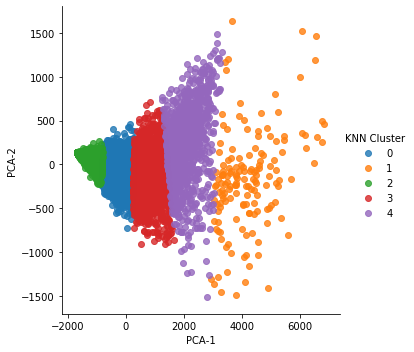

In [22]:
ax = sns.lmplot(x= "PCA-1", y= "PCA-2", hue= "KNN Cluster", data= preds_df, fit_reg= False)

In [32]:
mvp_dataset = preds_df[preds_df["MVP"] == 1]

mvp_dataset

,Players,MVP,Year,KNN Cluster,PCA-1,PCA-2
293,Shaquille O'Neal,1,2000,4,3320.904346,1280.375598
624,Allen Iverson,1,2001,4,2905.799664,1232.020269
1000,Tim Duncan,1,2002,4,3197.478660,865.546174
1428,Tim Duncan,1,2003,4,2904.459981,691.667295
1890,Kevin Garnett,1,2004,4,3129.092673,830.332345
2491,Steve Nash,1,2005,4,1515.354564,-26.031470
2948,Steve Nash,1,2006,4,1954.935855,136.229232
3413,Dirk Nowitzki,1,2007,4,2467.991608,796.445841
3635,Kobe Bryant,1,2008,4,3101.929936,1013.101994
4227,LeBron James,1,2009,4,2985.675575,1056.723619


In [25]:
"""
urls = []

for player in mvp_dataset["Players"]:
    
    try:
        player_page = wikipedia.page(player)
    except:
        pass
    
    img_url = player_page.images[0]
    
    urls.append(img_url)
"""

In [26]:
#fig, ax = plt.subplots(3, 6, figsize= (12, 12))

#fig.suptitle("NBA players with similar stats (Cluster %d)" % mvp_dataset["KNN Cluster"].values[0], fontsize= "x-large")